In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.interpolate import interp1d
from scipy.stats import wasserstein_distance
import pickle as pkl
import matplotlib.gridspec as gridspec

from HyperGraph import HyperGraph, HyperGraphAsymmetricSI, select_seeds, CSCM
from HyperGraphHelper import *
from fairness_measures import *
import real_world
from plot_scripts.plot_functions import create_homophily_barplot

# Synthetic

In this section, we demonstrate how to generate synthetic hypergraphs, explore their properties, run contagion processes over the hypergraphs, and quantify the equality/fairness of the spread.

This section includes:
- Information on the **hypergraph generator**,
- **Descriptive statistics** of the resulting hypergraphs,
- **Simulations of information spread** using the asymmetric SI model, and
- **Fairness metrics** quantifying how equitably different groups gain access to information.

## Hypergraph Generator

In [2]:
hypergraph_seed = np.random.randint(0, 2**32 - 1)

n0 = 5000 # nodes in group 0
n1 = 5000 # nodes in group 1

# m[k][t] is the number of edges of size k and with t nodes from group 1.
m = {
    2: {0: 7200, 1: 16520, 2: 1280}, 
    3: {0: 7626, 1: 3144, 2: 1052, 3: 178}, 
    4: {0: 2850, 1: 1938, 2: 970, 3: 215, 4: 27}
}

# Define the degree sampler 
degree_seed = np.random.randint(0, 2**32 - 1)
powerlaw = True
gamma = 2.9

degree_rng = np.random.default_rng(seed=degree_seed)
if powerlaw:
    degree_sampler = lambda n, kbar, gamma : ((gamma - 2.)/(gamma - 1.))*kbar*(1 + degree_rng.pareto(gamma - 1, size=n))
    params = (gamma,)
else: 
    degree_sampler = lambda n, kbar : degree_rng.poisson(kbar, size=n)
    params = ()
    
# Generate the hypergraph
edges, group, kappa = CSCM([n0,n1], m, degree_sampler, params=params, seed=hypergraph_seed)
H = HyperGraph(nodes=np.arange(0, n0+n1), edges=edges, group=group)

## Basic Hypergraph Stats

In [3]:
print(f'average realized degree: {np.mean([H.degree[v] for v in H.nodes]):.2f}')
print(f'average expected degree: {np.mean(list(kappa[0]) + list(kappa[1])):.2f}')
print(f'power inequality: {H.power_inequality():.2f}')
print(f'moment glass celing: {H.moment_glass_ceiling():.2f}')

average realized degree: 10.99
average expected degree: 11.15
power inequality: 0.37
moment glass celing: 0.17


### Homophily

In [4]:
# Get hyperedge homophily
h = H.homophily()

# Print hyperedge homophily for each hyperedge size and type
all_sizes = sorted(set(h[0].keys()) | set(h[1].keys()))
col_width = 45

print(f"{'Size':<5} | {'Group 0':<{col_width}} | {'Group 1':<{col_width}}")
print("-" * (7 + 2 + col_width + 3 + col_width))

for k in all_sizes:
    vec0 = []
    vec1 = []

    for i in range(k + 1):
        val0 = h[0].get(k, {}).get(i, '-   ')
        val1 = h[1].get(k, {}).get(i, '-   ')

        vec0.append(f"{val0:.2f}" if isinstance(val0, float) else val0)
        vec1.append(f"{val1:.2f}" if isinstance(val1, float) else val1)

    vec0_str = " ".join(vec0)
    vec1_str = " ".join(vec1)

    print(f"{k:<5} | {vec0_str:<{col_width}} | {vec1_str:<{col_width}}")

Size  | Group 0                                       | Group 1                                      
------------------------------------------------------------------------------------------------------
2     | -    1.07 0.93                                | -    1.73 0.27                               
3     | -    0.14 0.42 3.03                           | -    2.18 0.73 0.37                          
4     | -    0.09 0.27 0.80 4.71                      | -    3.35 1.12 0.37 0.19                     


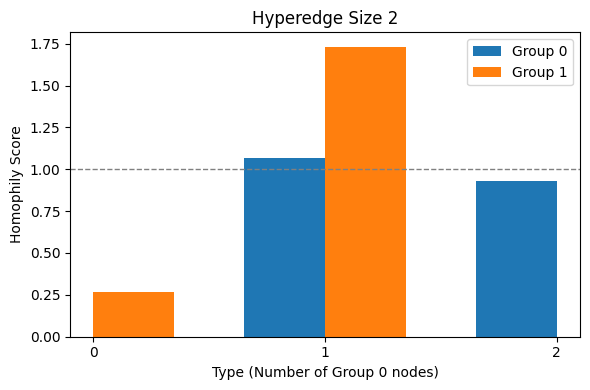

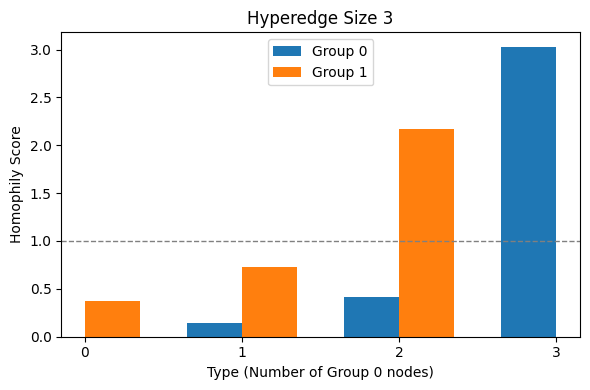

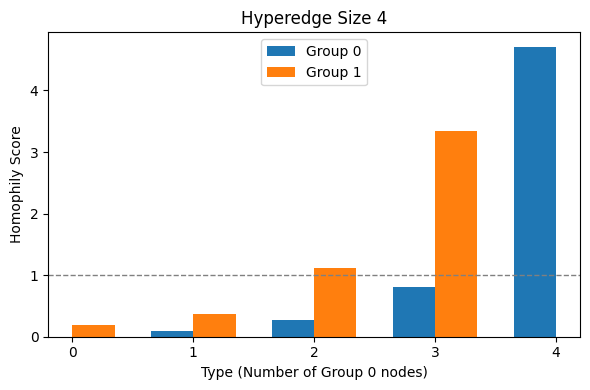

In [5]:
# Collect all sizes from both groups
all_sizes = sorted(set(h[0].keys()) | set(h[1].keys()))

# Plot one grouped bar chart per hyperedge size
for k in all_sizes:
    fig, ax = plt.subplots(figsize=(6, 4))

    x = list(range(k + 1))
    group0_vals = []
    group1_vals = []

    for i in range(k + 1):
        # For Group 0: direct index
        val0 = h[0].get(k, {}).get(i, np.nan)
        group0_vals.append(val0)

        # For Group 1: type i for group 1 means k - i group-0 nodes
        val1 = h[1].get(k, {}).get(k - i, np.nan)
        group1_vals.append(val1)

    bar_width = 0.35
    x_ticks = np.arange(k + 1)

    ax.bar(x_ticks - bar_width / 2, group0_vals, width=bar_width, label='Group 0', color='#1f77b4')
    ax.bar(x_ticks + bar_width / 2, group1_vals, width=bar_width, label='Group 1', color='#ff7f0e')

    ax.set_xticks(x_ticks)
    ax.set_xticklabels([str(i) for i in range(k + 1)])
    ax.set_xlabel("Type (Number of Group 0 nodes)")
    ax.set_ylabel("Homophily Score")
    ax.set_title(f"Hyperedge Size {k}")
    ax.legend()
    ax.axhline(1.0, color='gray', linestyle='--', linewidth=1)
    ax.set_ylim(bottom=0)

    plt.tight_layout()
    plt.show()

### Degree distribution

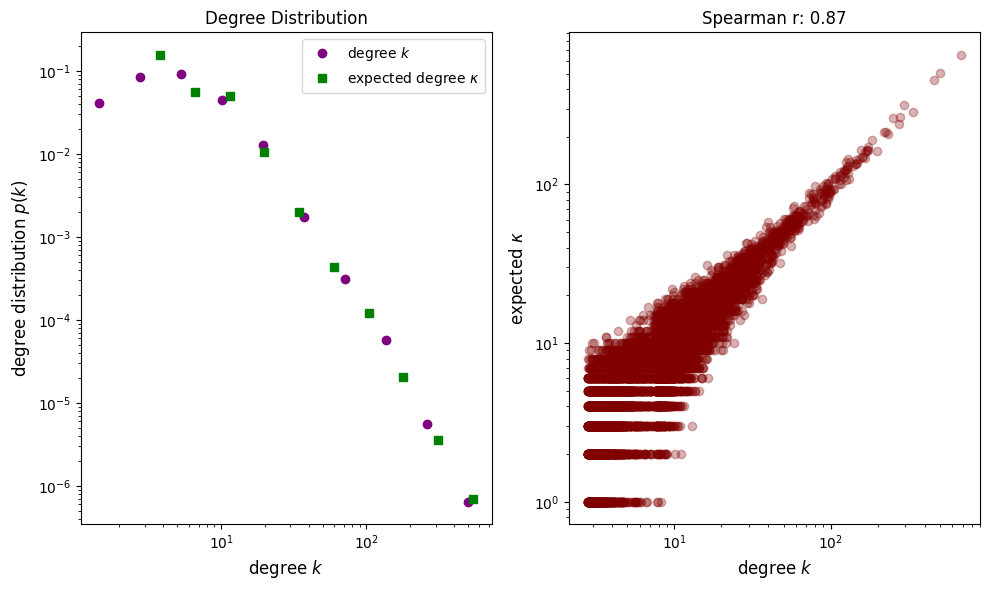

In [6]:
logbin = True
fs = 12
figsize=(10, 6)

## Calculate Degree Distribution ##

degrees = np.array([H.degree[i] for i in H.nodes])
kappas = np.array(list(kappa[0]) + list(kappa[1]))



if logbin:
    counts_k, mids_k, _ = logbinning(degrees)
    counts_kappa, mids_kappa, _ = logbinning(kappas)

else:
    counts_k, mids_k, _ = linbinning(degrees)
    counts_k, mids_kappa, _ = linbinning(kappas)

fig = plt.figure(figsize=figsize)

ax1 = fig.add_subplot(121)
ax1.plot(mids_k, counts_k, marker='o', ls='', color='purple',)
ax1.plot(mids_kappa, counts_kappa, marker='s', ls='', color='green')
ax1.set_title('Degree Distribution', fontsize=fs)
ax1.set_ylabel(r'degree distribution $p(k)$', fontsize=fs)
ax1.set_xlabel(r'degree $k$', fontsize=fs)
ax1.legend([r'degree $k$', r'expected degree $\kappa$'], fontsize=fs-2)

if logbin:
    ax1.set_xscale('log')
    ax1.set_yscale('log')


ax2 = fig.add_subplot(122)

ax2.scatter(kappas, degrees, marker='o', alpha=0.3, color='maroon')
ax2.set_title(f'Spearman r: {stats.spearmanr(list(kappa[0])+list(kappa[1]), [H.degree[i] for i in H.nodes])[0]:.2f}')
ax2.set_ylabel(r'expected $\kappa$', fontsize=fs)
ax2.set_xlabel(r'degree $k$', fontsize=fs)

if logbin:
    ax2.set_xscale('log')
    ax2.set_yscale('log')

fig.tight_layout()

## Simulating information spread on synthetic hypergraphs

In [7]:
# Set random seeds and parameters
hypergraph_seed = 1230
degree_seed = 42
n0, n1 = 7500, 2500
num_nodes = n0 + n1

# Edge composition: m[k][t] is number of edges of size k with t nodes from group 1
m = {
    2: {0: 8334, 1: 8332, 2: 8334}, 
    3: {0: 2122, 1: 3878, 2: 3878, 3: 2122},
    4: {0: 546, 1: 1403, 2: 2102, 3: 1403, 4: 546}
}

# Degree sampler
powerlaw = False
gamma = 2.5
degree_rng = np.random.default_rng(seed=degree_seed)
if powerlaw:
    degree_sampler = lambda n, kbar, gamma: ((gamma - 2.) / (gamma - 1.)) * kbar * (1 + degree_rng.pareto(gamma - 1, size=n))
    params = (3.0,)
else:
    degree_sampler = lambda n, kbar: degree_rng.poisson(kbar, size=n)
    params = ()

# Generate synthetic hypergraph
edges, group, kappa = CSCM([n0, n1], m, degree_sampler, params=params, seed=hypergraph_seed)
H = HyperGraph(nodes=np.arange(num_nodes), edges=edges, group=group)

# Infection simulation parameters
num_runs = 20
num_seeds = 1
sp_m = 0.0
seed_strategy = 'random'
nus = np.array([[2.0, 0.5], [2.0, 0.5]])
lams = np.array([[0.01, 0.01], [0.01, 0.01]])

# Storage for simulation results
all_node_seqs = []
all_time_seqs = []
all_infected_total = []
all_infected_majority = []
all_infected_minority = []
all_group_seqs = []

# Run simulations
for _ in range(num_runs):
    hASI = HyperGraphAsymmetricSI(
        nodes=np.arange(num_nodes),
        edges=edges,
        group=group,
        nus=nus,
        lams=lams,
        fast=True,
        samplable_set=True
    )

    seeds = select_seeds(seed_strategy, hASI, num_seeds, sp_m)
    hASI.set_initial_condition(seeds)

    state_seq, time_seq, node_seq, group_seq, *_ = hASI.simulate(maxiter=10000, verbose=False)

    # Store time and infection counts
    all_node_seqs.append(node_seq)
    all_time_seqs.append(time_seq)
    all_infected_total.append(state_seq)

    # Group-specific infection counts
    infected_majority = [np.sum((hASI.group == 0) & (hASI.node_state == 1))]
    infected_minority = [np.sum((hASI.group == 1) & (hASI.node_state == 1))]
    for t in range(1, len(time_seq)):
        node = node_seq[t]
        if node is None:
            continue
        g = group[node]
        if g == 0:
            infected_majority.append(infected_majority[-1] + 1)
            infected_minority.append(infected_minority[-1])
        else:
            infected_majority.append(infected_majority[-1])
            infected_minority.append(infected_minority[-1] + 1)

    all_infected_majority.append(infected_majority)
    all_infected_minority.append(infected_minority)
    all_group_seqs.append(group_seq)

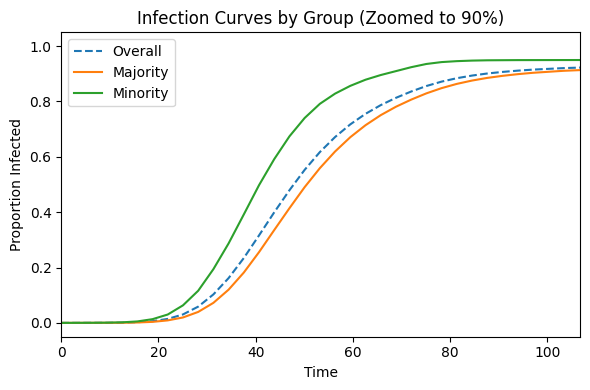

In [8]:
# Get group sizes for normalization
group = np.array(group)
n_total = H.N
n_maj = np.sum(group == 0)
n_min = np.sum(group == 1)
max_T = int(np.max([ts[-1] for ts in all_time_seqs]))
time_grid = np.linspace(0, max_T, 300)

# Normalize curves
interp_maj = np.array([
    np.interp(time_grid, ts[:len(inf)], inf) for ts, inf in zip(all_time_seqs, all_infected_majority)
])
interp_min = np.array([
    np.interp(time_grid, ts[:len(inf)], inf) for ts, inf in zip(all_time_seqs, all_infected_minority)
])
interp_maj_prop = interp_maj / n_maj
interp_min_prop = interp_min / n_min

# Compute weighted total infection proportion
interp_total_prop = (
    interp_maj_prop * (n_maj / n_total) +
    interp_min_prop * (n_min / n_total)
)

# Compute means and HPDIs
mean_total = np.mean(interp_total_prop, axis=0)
low_total, high_total = hpdi(interp_total_prop, p=0.9)

mean_maj = np.mean(interp_maj_prop, axis=0)
low_maj, high_maj = hpdi(interp_maj_prop, p=0.9)

mean_min = np.mean(interp_min_prop, axis=0)
low_min, high_min = hpdi(interp_min_prop, p=0.9)

# Determine time of 90% infection
t_total_90 = time_grid[np.argmax(mean_total >= 0.9)]
t_maj_90 = time_grid[np.argmax(mean_maj >= 0.9)]
t_min_90 = time_grid[np.argmax(mean_min >= 0.9)]
zoom_limit = max(t_total_90, t_maj_90, t_min_90) * 1.1  # 10% padding

# Plot
plt.figure(figsize=(6, 4))

plt.plot(time_grid, mean_total, linestyle='--', label='Overall')
plt.plot(time_grid, mean_maj, label='Majority')
plt.plot(time_grid, mean_min, label='Minority')

plt.xlabel("Time")
plt.ylabel("Proportion Infected")
plt.title("Infection Curves by Group (Zoomed to 90%)")
plt.xlim([0, zoom_limit])  # Apply zoom here
plt.legend()
plt.tight_layout()
plt.show()

## Measuring information access inequality

In [9]:
# Compute the EMD between the group-wise infection ranks
def compute_emd_on_ranks(node_seqs, group):
    emd_values = []
    group = np.array(group)

    for nodes in node_seqs:
        rank = np.full(len(group), np.inf)
        for t, node in enumerate(nodes):
            if node is not None:
                rank[node] = t

        majority_ranks = rank[group == 0]
        minority_ranks = rank[group == 1]

        majority_ranks = majority_ranks[np.isfinite(majority_ranks)]
        minority_ranks = minority_ranks[np.isfinite(minority_ranks)]

        if len(majority_ranks) > 0 and len(minority_ranks) > 0:
            emd = wasserstein_distance(majority_ranks, minority_ranks)
            emd_values.append(emd)

    return emd_values

In [10]:
emd_values = compute_emd_on_ranks(all_node_seqs, group)

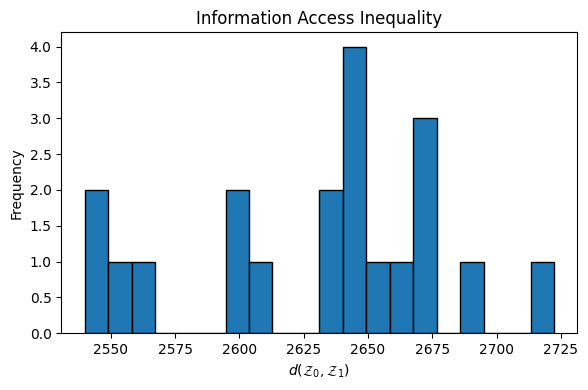

In [11]:
plt.figure(figsize=(6, 4))
plt.hist(emd_values, bins=20, edgecolor='black')
plt.xlabel(r"$d(\mathcal{Z}_0, \mathcal{Z}_1)$")
plt.ylabel("Frequency")
plt.title("Information Access Inequality")
plt.tight_layout()
plt.show()

Note: max inequality is N/2 = 5000

### Acquisition fairness

Here, we show how to calculate acquisition fairness [Zappalà et al. (2024)], the the average of the ratio of fraction of minority nodes reached to the fraction of minority nodes in the network at the time when a fraction f of all nodes has been reached by the information spread. The function assumes that nodes of group 1 are the minority nodes.

If acquisition fairness is greater than 1.0, there's a majority advantage. Conversely, there's a minority advantage if acquisition fairness is less than 1.0, and we consider the spread to be fair if acquisition fairness equals 1.0.

In [12]:
# Clean to remove null values
all_group_seqs = [
    np.array([group[node] for node in node_seq if node is not None])
    for node_seq in all_node_seqs
]

# Calculate aquisition fairness
af = acquisition_fairness(all_group_seqs, n=[n0, n1], f=0.9)
print(f"Acquisition Fairness at 90% infection: {af:.3f}")

Acquisition Fairness at 90% infection: 1.108


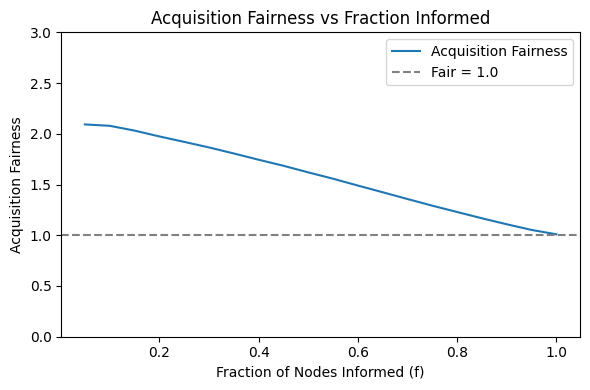

In [13]:
# Sweep f values from 0.05 to 1.0
f_values = np.linspace(0.05, 1.0, 20)
af_values = []

# Reconstruct group sequences if needed
all_group_seqs = [
    np.array([group[node] for node in node_seq if node is not None])
    for node_seq in all_node_seqs
]

# Compute acquisition fairness for each f
for f in f_values:
    af = acquisition_fairness(all_group_seqs, n=[n0, n1], f=f)
    af_values.append(af)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(f_values, af_values, label='Acquisition Fairness')
plt.axhline(1.0, linestyle='--', color='gray', label='Fair = 1.0')
plt.xlabel("Fraction of Nodes Informed (f)")
plt.ylabel("Acquisition Fairness")
plt.ylim([0, 3.0])
plt.title("Acquisition Fairness vs Fraction Informed")
plt.legend()
plt.tight_layout()
plt.show()

### Diffusion fairness

Here, we show how to calculate diffusion fairness [Zappalà et al. (2024)], the quotient of the average duration of spread when seeds are in the minority group and when seeds are in the majority group. The function assumes that nodes of group 1 are the minority nodes.

If diffusion fairness is greater than 1.0, there's a majority advantage. Conversely, there's a minority advantage if diffusion fairness is less than 1.0, and we consider the spread to be fair if diffusion fairness equals 1.0.

In [14]:
# Infection simulation parameters
num_runs = 5
num_seeds = 1
seed_strategy = 'random'
nus = np.array([[2.0, 0.5], [2.0, 0.5]])
lams = np.array([[0.01, 0.01], [0.01, 0.01]])

# Simulate contagion with majority seeding
sp_m = 0.0

hASI = HyperGraphAsymmetricSI(
    nodes=np.arange(num_nodes),
    edges=edges,
    group=group,
    nus=nus,
    lams=lams,
    fast=True,
    samplable_set=True
)

seeds = select_seeds(seed_strategy, hASI, num_seeds, sp_m)
hASI.set_initial_condition(seeds)

state_seq_maj, time_seq_maj, node_seq_maj, group_seq_maj, *_maj = hASI.simulate(maxiter=10000, verbose=False)

# Simulate contagion with minority seeding
sp_m = 1.0

hASI = HyperGraphAsymmetricSI(
    nodes=np.arange(num_nodes),
    edges=edges,
    group=group,
    nus=nus,
    lams=lams,
    fast=True,
    samplable_set=True
)

seeds = select_seeds(seed_strategy, hASI, num_seeds, sp_m)
hASI.set_initial_condition(seeds)

state_seq_min, time_seq_min, node_seq_min, group_seq_min, *_min = hASI.simulate(maxiter=10000, verbose=False)

In [15]:
# Wrap in lists first, even if you only have one run
time_sequences_majority = [np.array(time_seq_maj)]
time_sequences_minority = [np.array(time_seq_min)]

# Calculate diffusion fairness
df = diffusion_fairness(time_sequences_majority, time_sequences_minority, N=H.N, f=0.9)
print(f"Diffusion Fairness at 90% infection: {df:.3f}")

Diffusion Fairness at 90% infection: 1.150


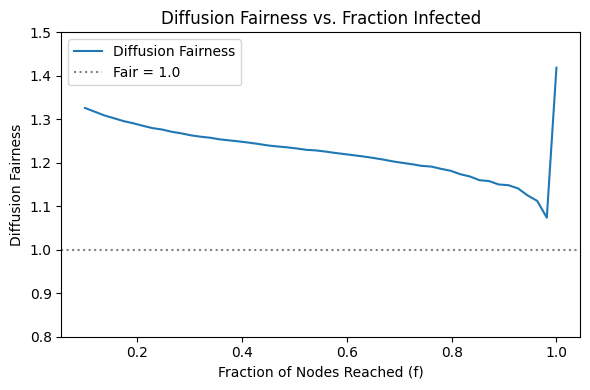

In [16]:
# Sweep over f from 0.1 to 1.0
f_values = np.linspace(0.1, 1.0, 50)
df_values = []

for f in f_values:
    try:
        df = diffusion_fairness(time_sequences_majority, time_sequences_minority, N=H.N, f=f)
        df_values.append(df)
    except Exception as e:
        print(f"Error at f={f:.2f}: {e}")
        df_values.append(np.nan)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(f_values, df_values, label="Diffusion Fairness")
plt.axhline(1.0, linestyle='dotted', color='gray', label="Fair = 1.0")
plt.xlabel("Fraction of Nodes Reached (f)")
plt.ylabel("Diffusion Fairness")
plt.ylim([0.8, 1.5])
plt.title("Diffusion Fairness vs. Fraction Infected")
plt.legend()
plt.tight_layout()
plt.show()

# Real-World 

In this section, we demonstrate how to process and analyze real-world data using the hypergraph-based simulation pipeline described in our paper. We focus on the dummy datasets `dummy_hospital` and `dummy_highschool`, which are structurally similar to our real datasets but contain no private information.

This section includes:
- **Data cleaning and hypergraph generation** from downloaded real-world data,
- **Descriptive statistics** of the resulting hypergraphs,
- **Simulations of information spread** using the asymmetric SI model, and
- **Fairness metrics** quantifying how equitably different groups gain access to information.

For additional information on downloading and preparing the real-world data, see the README.

In [17]:
datasets = ['dummy_hospital', 'dummy_highschool']

## Data preparation with dummy data

In [18]:
real_world.clean(datasets=datasets, data_dir='data/real_world/')

## Hypergraph construction with dummy data

In [19]:
real_world.generate_lcc_hypergraphs(datasets=datasets, 
                                    base_path='data/real_world/', 
                                    pred_gender=False, 
                                    num_hypergraphs=1)

[Info] Adding 'lcc_id' to metadata for dummy_hospital
dummy_hospital: 30 nodes, 23 edges, rank 5, group sizes [24, 6]
[Info] Adding 'lcc_id' to metadata for dummy_highschool
dummy_highschool: 27 nodes, 27 edges, rank 5, group sizes [16, 11]


## Measuring real-world hypergraph properties

In [20]:
# Load the hypergraph
dummy_hospital_fp = 'data/real_world/dummy_hospital/hypergraphs/dummy_hospital_lcc_hg.pkl'
with open(dummy_hospital_fp, 'rb') as f:
    H = pkl.load(f)
    edges = H.edges
    group = H.group
    kappa = H.degree
    num_nodes = H.N

# Print hypergraph properties/statistics
print("Number of nodes:", H.N)
print("Number of edges:", H.M)
print("Max edge size (rank):", H.rank)
print("Average degree:", np.mean(list(H.degree.values())))
print("Power inequality:", H.power_inequality())
print("Moment glass ceiling:", H.moment_glass_ceiling())

Number of nodes: 30
Number of edges: 23
Max edge size (rank): 5
Average degree: 2.6
Power inequality: 0.5882352941176471
Moment glass ceiling: 0.3252032520325203


In [21]:
# Get hyperedge homophily
h = H.homophily()

# Print hyperedge homophily for each hyperedge size and type
all_sizes = sorted(set(h[0].keys()) | set(h[1].keys()))
col_width = 45

print(f"{'Size':<5} | {'Group 0':<{col_width}} | {'Group 1':<{col_width}}")
print("-" * (7 + 2 + col_width + 3 + col_width))

for k in all_sizes:
    vec0 = []
    vec1 = []

    for i in range(k + 1):
        val0 = h[0].get(k, {}).get(i, '-   ')
        val1 = h[1].get(k, {}).get(i, '-   ')

        vec0.append(f"{val0:.2f}" if isinstance(val0, float) else val0)
        vec1.append(f"{val1:.2f}" if isinstance(val1, float) else val1)

    vec0_str = " ".join(vec0)
    vec1_str = " ".join(vec1)

    print(f"{k:<5} | {vec0_str:<{col_width}} | {vec1_str:<{col_width}}")

Size  | Group 0                                       | Group 1                                      
------------------------------------------------------------------------------------------------------
2     | -    -    1.25                                | -    -    -                                  
3     | -    -    1.04 1.04                           | -    1.56 -    -                             
4     | -    -    1.60 0.60 1.20                      | -    0.65 1.74 -    -                        
5     | -    -    -    -    0.70 1.74                 | -    2.44 -    -    -    -                   


Note: a '-' means there is no homophily value since there are no hyperedges of that type in the hypergraph.
Values greater than 1.0 occur more often than expected (i.e., homophilous hyperedge types).

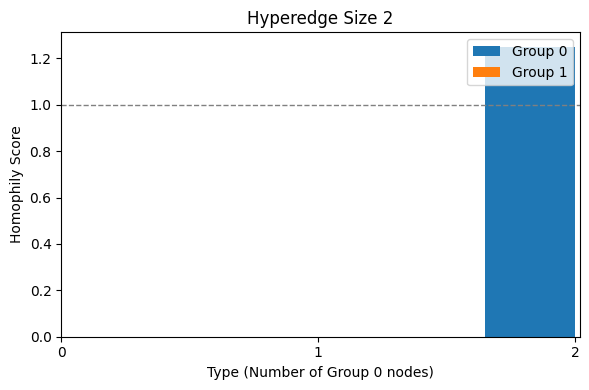

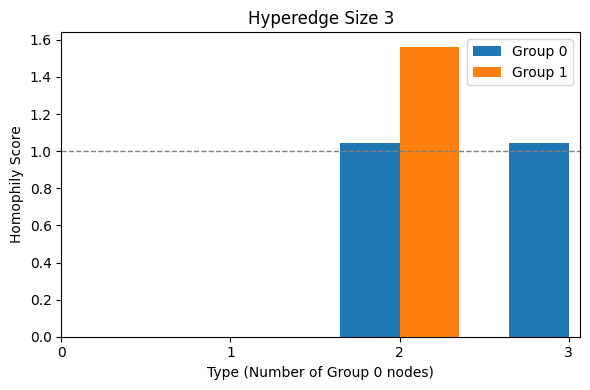

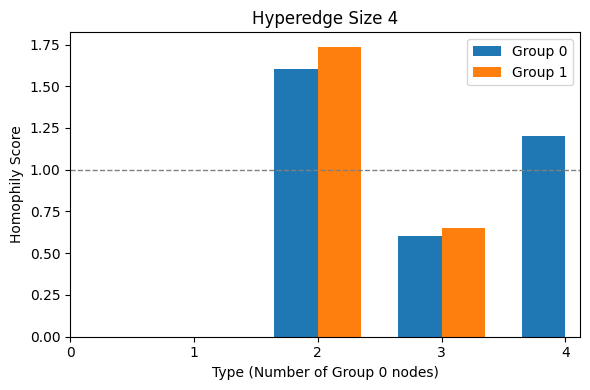

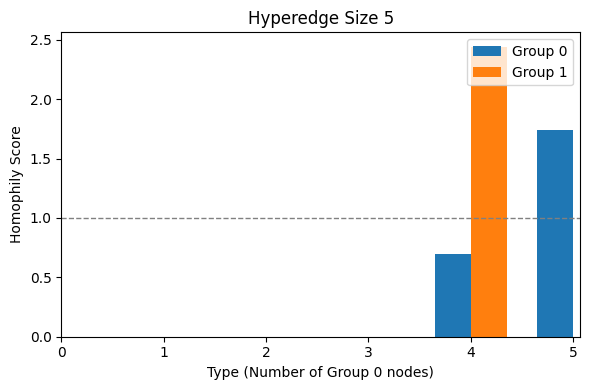

In [22]:
# Collect all sizes from both groups
all_sizes = sorted(set(h[0].keys()) | set(h[1].keys()))

# Plot one grouped bar chart per hyperedge size
for k in all_sizes:
    fig, ax = plt.subplots(figsize=(6, 4))

    x = list(range(k + 1))
    group0_vals = []
    group1_vals = []

    for i in range(k + 1):
        # For Group 0: direct index
        val0 = h[0].get(k, {}).get(i, np.nan)
        group0_vals.append(val0)

        # For Group 1: type i for group 1 means k - i group-0 nodes
        val1 = h[1].get(k, {}).get(k - i, np.nan)
        group1_vals.append(val1)

    bar_width = 0.35
    x_ticks = np.arange(k + 1)

    ax.bar(x_ticks - bar_width / 2, group0_vals, width=bar_width, label='Group 0', color='#1f77b4')
    ax.bar(x_ticks + bar_width / 2, group1_vals, width=bar_width, label='Group 1', color='#ff7f0e')

    ax.set_xticks(x_ticks)
    ax.set_xticklabels([str(i) for i in range(k + 1)])
    ax.set_xlabel("Type (Number of Group 0 nodes)")
    ax.set_ylabel("Homophily Score")
    ax.set_title(f"Hyperedge Size {k}")
    ax.legend()
    ax.axhline(1.0, color='gray', linestyle='--', linewidth=1)
    ax.set_ylim(bottom=0)

    plt.tight_layout()
    plt.show()

## Simulating information spread on real-world hypergraphs

In [23]:
# Parameters
num_runs = 100
num_seeds = 1
sp_m = 0.0
seed_strategy = 'random'
nus = np.array([[1.0, 1.0], [1.0, 1.0]])
lams = np.array([[0.01, 0.01], [0.01, 0.01]])

# Prepare to store infection trajectories
all_node_seqs = []
all_time_seqs = []
all_infected_total = []
all_infected_majority = []
all_infected_minority = []

# Run simulations
for _ in range(num_runs):
    hASI = HyperGraphAsymmetricSI(
        nodes=np.arange(num_nodes), 
        edges=edges, 
        group=group, 
        nus=nus, 
        lams=lams, 
        fast=True, 
        samplable_set=True
    )
    
    seeds = select_seeds(seed_strategy, hASI, num_seeds, sp_m)
    hASI.set_initial_condition(seeds)

    state_seq, time_seq, node_seq, group_seq, *_ = hASI.simulate(maxiter=10000, verbose=False)

    # Store time and infection counts
    all_node_seqs.append(node_seq)
    all_time_seqs.append(time_seq)
    all_infected_total.append(state_seq)
    
    # Group-specific infection counts
    infected_majority = [np.sum((hASI.group == 0) & (hASI.node_state == 1))]
    infected_minority = [np.sum((hASI.group == 1) & (hASI.node_state == 1))]
    for t in range(1, len(time_seq)):
        node = node_seq[t]
        if node is None:
            continue
        g = group[node]
        if g == 0:
            infected_majority.append(infected_majority[-1] + 1)
            infected_minority.append(infected_minority[-1])
        else:
            infected_majority.append(infected_majority[-1])
            infected_minority.append(infected_minority[-1] + 1)

    all_infected_majority.append(infected_majority)
    all_infected_minority.append(infected_minority)

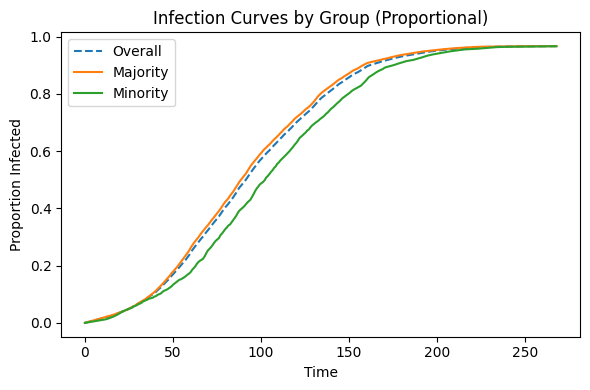

In [24]:
# Get group sizes for normalization
group = np.array(group)
n_total = H.N
n_maj = np.sum(group == 0)
n_min = np.sum(group == 1)
max_T = int(np.max([ts[-1] for ts in all_time_seqs]))
time_grid = np.linspace(0, max_T, 300)

# Normalize curves
interp_maj = np.array([
    np.interp(time_grid, ts[:len(inf)], inf) for ts, inf in zip(all_time_seqs, all_infected_majority)
])
interp_min = np.array([
    np.interp(time_grid, ts[:len(inf)], inf) for ts, inf in zip(all_time_seqs, all_infected_minority)
])
interp_maj_prop = interp_maj / n_maj
interp_min_prop = interp_min / n_min

# Compute weighted total infection proportion
interp_total_prop = (
    interp_maj_prop * (n_maj / n_total) +
    interp_min_prop * (n_min / n_total)
)

# Compute means and HPDIs
mean_total = np.mean(interp_total_prop, axis=0)
low_total, high_total = hpdi(interp_total_prop, p=0.9)

mean_maj = np.mean(interp_maj_prop, axis=0)
low_maj, high_maj = hpdi(interp_maj_prop, p=0.9)

mean_min = np.mean(interp_min_prop, axis=0)
low_min, high_min = hpdi(interp_min_prop, p=0.9)

# Plot
plt.figure(figsize=(6, 4))

plt.plot(time_grid, mean_total, linestyle='--', label='Overall')
plt.plot(time_grid, mean_maj, label='Majority')
plt.plot(time_grid, mean_min, label='Minority')

plt.xlabel("Time")
plt.ylabel("Proportion Infected")
plt.title("Infection Curves by Group (Proportional)")
plt.legend()
plt.tight_layout()
plt.show()

## Measuring information access inequality

In [25]:
# Compute the EMD between the group-wise infection ranks
def compute_emd_on_ranks(node_seqs, group):
    emd_values = []
    group = np.array(group)

    for nodes in node_seqs:
        rank = np.full(len(group), np.inf)
        for t, node in enumerate(nodes):
            if node is not None:
                rank[node] = t

        majority_ranks = rank[group == 0]
        minority_ranks = rank[group == 1]

        majority_ranks = majority_ranks[np.isfinite(majority_ranks)]
        minority_ranks = minority_ranks[np.isfinite(minority_ranks)]

        if len(majority_ranks) > 0 and len(minority_ranks) > 0:
            emd = wasserstein_distance(majority_ranks, minority_ranks)
            emd_values.append(emd)

    return emd_values

In [26]:
emd_values = compute_emd_on_ranks(all_node_seqs, group)

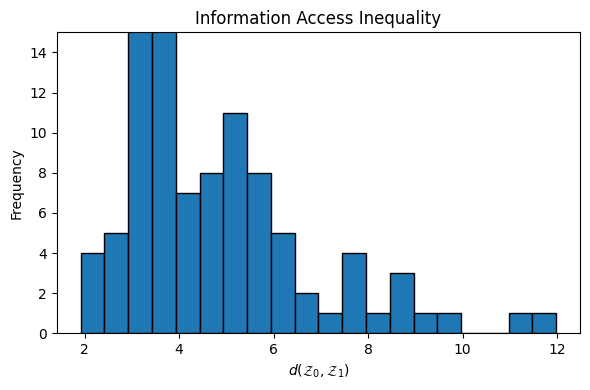

In [27]:
plt.figure(figsize=(6, 4))
plt.hist(emd_values, bins=20, edgecolor='black')
plt.xlabel(r"$d(\mathcal{Z}_0, \mathcal{Z}_1)$")
plt.ylabel("Frequency")
plt.ylim([0, H.N/2])
plt.title("Information Access Inequality")
plt.tight_layout()
plt.show()

Note: max inequality is N/2 = 15